In [4]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
# from torch.utils.data import *

import time
import random
import re

import matplotlib.pyplot as plt 
%matplotlib inline

import pdb
from tqdm.auto import tqdm

```
Summary
=======

This dataset (ml-latest-small) describes 5-star rating and free-text tagging activity from [MovieLens](http://movielens.org), a movie recommendation service. It contains 100836 ratings and 3683 tag applications across 9742 movies. These data were created by 610 users between March 29, 1996 and September 24, 2018. This dataset was generated on September 26, 2018.

Users were selected at random for inclusion. All selected users had rated at least 20 movies. No demographic information is included. Each user is represented by an id, and no other information is provided.

The data are contained in the files `links.csv`, `movies.csv`, `ratings.csv` and `tags.csv`. More details about the contents and use of all these files follows.
```

In [14]:
# https://grouplens.org/datasets/movielens/

links = pd.read_csv("ml-latest-small/links.csv")
movies = pd.read_csv("ml-latest-small/movies.csv")
ratings = pd.read_csv("ml-latest-small/ratings.csv")
tags = pd.read_csv("ml-latest-small/tags.csv")

In [15]:
links.head(3)

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0


In [16]:
movies.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [20]:
ratings.head(5)

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [23]:
tags.head(3)

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992


```

MovieLens data sets were collected by the GroupLens Research Project
at the University of Minnesota.
 
This data set consists of:
* 100,000 ratings (1-5) from 943 users on 1682 movies. 
* Each user has rated at least 20 movies. 
* Simple demographic info for the users (age, gender, occupation, zip)
        
        
u1.base    -- The data sets u1.base and u1.test through u5.base and u5.test
u1.test       are 80%/20% splits of the u data into training and test data.
u2.base       Each of u1, ..., u5 have disjoint test sets; this if for
u2.test       5 fold cross validation (where you repeat your experiment
u3.base       with each training and test set and average the results).
u3.test       These data sets can be generated from u.data by mku.sh.
u4.base
u4.test
u5.base
u5.test



u.data     -- The full u data set, 100000 ratings by 943 users on 1682 items.
              Each user has rated at least 20 movies.  
              Users and items are numbered consecutively from 1.  
              The data is randomly ordered. 
              This is a tab separated list of user id | item id | rating | timestamp. 
              The time stamps are unix seconds since 1/1/1970 UTC   
```

In [5]:
def load_data(filename):
    data_list = []
    with open(filename, 'r') as data:
        for line in tqdm(data):
            user_id, item_id, rating, timestamp = line.split('\t')
            data_list.append([int(user_id), int(item_id), int(rating)])
            
    print('data loading complete')
    return data_list

def torch_load_data(filename):
    data_list = []
    with open(filename, 'r') as data:
        for line in tqdm(data):
            user_id, item_id, rating, timestamp = line.split('\t')
            data_list.append(torch.tensor([int(user_id), int(item_id), int(rating)]))
    print('data loading complete')
    return data_list

def torch_load_data_csv(filename='ml-latest-small/ratings.csv'):
    '''user_id, item_id, rating, timestamp
    '''
    data_list = []
    df = pd.read_csv(filename)
    print(df.columns)
    print(df.shape)
    for line in df.values:
        data_list.append(torch.tensor([int(line[0]), int(line[1]), int(line[2])]))
    print('data loading complete')
    return data_list


def data_handler():
    
    def data():
        data_list = []
        filename = 'ml-100k/u.data'
        with open(filename, 'r') as data:
            for line in tqdm(data):
                user_id, item_id, rating, timestamp = line.split('\t')
                data_list.append([int(user_id), int(item_id), int(rating), timestamp.strip()])
        print('data loading complete')

        df = pd.DataFrame(data_list, columns =['user_id', 'movie_id', 'rating', 'timestamp'])
        return df 
    
    def item():
        data_list = []
        filename = 'ml-100k/u.item'
        with open(filename, 'r', encoding="ISO-8859-1") as data:
            for line in tqdm(data):
                lst = line.split('|')
                lst = [ele.strip() for ele in lst]
                data_list.append(lst)

        print('data loading complete')

        columns = [ 'movie_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown', \
                    'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', \
                    'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci_Fi', 'Thriller', 'War', 'Western'] 

        df = pd.DataFrame(data_list, columns =columns)
        return df 
    
    data = data()
    item = item()
    return data, item

In [6]:
ratings, item = data_handler()


data loading complete



data loading complete


In [7]:
ratings.head()

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [9]:
ratings.describe()

,user_id,movie_id,rating
count,100000.00000,100000.000000,100000.000000
mean,462.48475,425.530130,3.529860
std,266.61442,330.798356,1.125674
min,1.00000,1.000000,1.000000
25%,254.00000,175.000000,3.000000
50%,447.00000,322.000000,4.000000
75%,682.00000,631.000000,4.000000
max,943.00000,1682.000000,5.000000


No handles with labels found to put in legend.
No handles with labels found to put in legend.


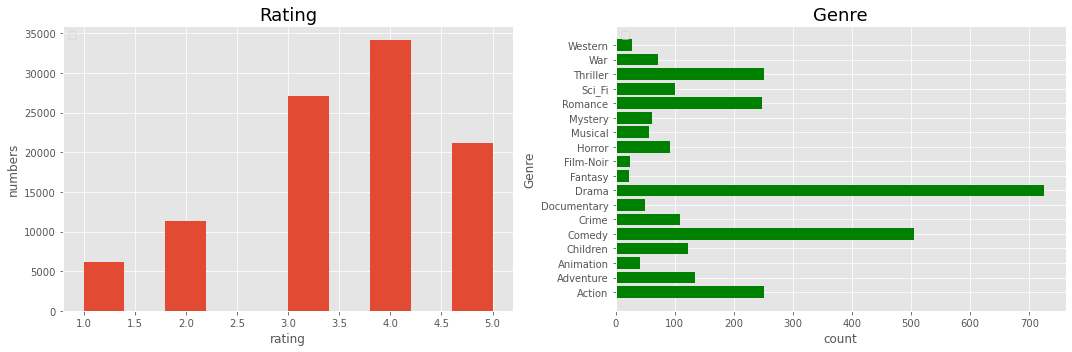

In [87]:
# Plot the progression of the classification accuracy over 20 epoach.
plt.style.use('ggplot')

fig, ax = plt.subplots(1,2,figsize=(15,5))

# summarize for accuracy
ax[0].hist(ratings['rating'])

ax[0].set_title('Rating',fontsize=18)
ax[0].set_ylabel('numbers')
ax[0].set_xlabel('rating')
ax[0].legend(loc='upper left')



# summarize for loss 

pick = item.iloc[:,6:]
columns = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime','Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical','Mystery', 'Romance', 'Sci_Fi', 'Thriller', 'War', 'Western']

lst = []
for name in columns:
    count = pick[name].astype(int).sum()
    lst.append(count)

x_pos = [i for i, _ in enumerate(columns)]
ax[1].barh(x_pos, lst, color='green')

ax[1].set_yticks(x_pos) # values
ax[1].set_yticklabels(columns) # labels

ax[1].set_title('Genre',fontsize=18)
ax[1].set_ylabel('Genre')
ax[1].set_xlabel('count')
ax[1].legend(loc='upper left')

plt.tight_layout()